# Imports

In [1]:
import requests
import datetime
import time
import pandas as pd
import numpy as np
import re
import csv
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from textatistic import Textatistic
from textblob import TextBlob
from scipy import stats
from scipy.special import inv_boxcox

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go 
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True) 
%matplotlib inline
sns.set_style(style='darkgrid')
plt.rcParams["patch.force_edgecolor"]=True

# Load Sample Data

In [4]:
kiva = pd.read_pickle('kiva_423.pkl')

In [5]:
#Create subset that is just loans that received funding.
kiva = kiva[kiva['STATUS'] == 'funded']

In [6]:
_,lmb_days = stats.boxcox(kiva['DAYS_TO_FUND'].dropna())
_,lmb_loan = stats.boxcox(kiva['LOAN_AMOUNT'].dropna())

In [7]:
kiva = kiva[kiva['BORROWERS_TOTAL'].isnull() ==False]
kiva = kiva[kiva['DAYS_TO_FUND'].isnull() == False]
kiva = kiva[kiva['LOAN_BOX'].isnull() == False]
kiva = kiva[kiva['FLESCH_SCORE'].isnull() == False]

# Initial visualization of the data

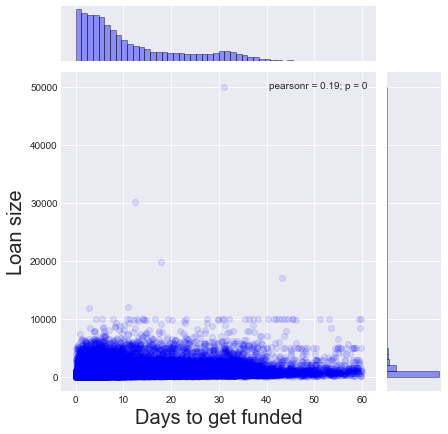

In [8]:
#viewing the correlation between days to funding and amount funded
e = sns.jointplot(x='DAYS_TO_FUND', y='FUNDED_AMOUNT', data=kiva, kind='scatter',color='blue',alpha=.1)
e.ax_joint.set_xlabel('Days to get funded', size=20)
e.ax_joint.set_ylabel('Loan size', size=20)
plt.savefig('Days_Loan.png', dpi=300)

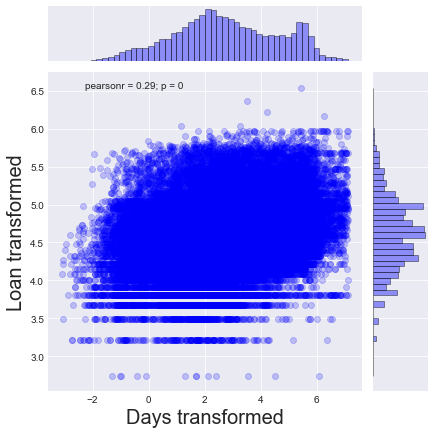

In [9]:
#Same plot as above but log transformed funded amount, and sqrt transformed days
f = sns.jointplot(x='DAYS_BOX', y='LOAN_BOX', data=kiva, kind='scatter', color='blue', alpha=.2)
f.ax_joint.set_xlabel('Days transformed', size=20)
f.ax_joint.set_ylabel('Loan transformed', size=20)
plt.savefig('Days_Loan_Trans.png', dpi=300)

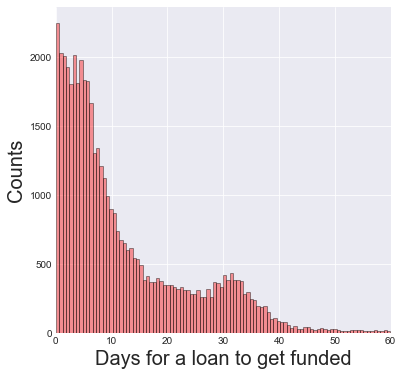

In [10]:
#plot of how long it takes projects to get funded
g=sns.distplot(kiva['DAYS_TO_FUND'].dropna(), kde=False, color='red', bins = 100)
g.figure.set_size_inches(6,6)
g.set_xlabel('Days for a loan to get funded', size=20)
g.set_ylabel('Counts', size=20)
g.set_xlim(0, 60)
plt.savefig('Days_to_fund.png', dpi=300)

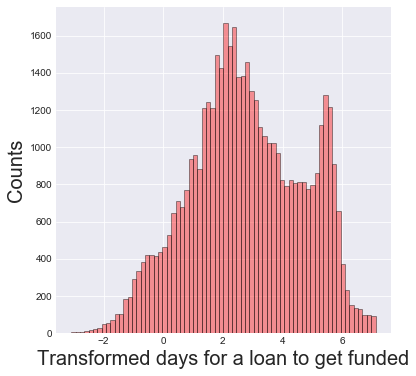

In [11]:
#plot of how long it takes projects to get funded
h=sns.distplot(kiva['DAYS_BOX'].dropna(), kde=False, color='red', bins = 70)
h.figure.set_size_inches(6,6)
h.set_ylabel('Counts', size=20)
h.set_xlabel('Transformed days for a loan to get funded', size=20)
plt.savefig('Days_transformed.png', dpi=300)

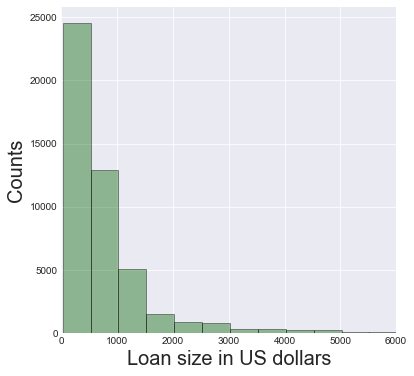

In [12]:
#plot of how long it takes projects to get funded
i=sns.distplot(kiva['LOAN_AMOUNT'].dropna(), kde=False, color='darkgreen', bins = 100)
i.figure.set_size_inches(6,6)
i.set_xlabel('Loan size in US dollars', size=20)
i.set_ylabel('Counts', size=20)
i.set_xlim(0, 6000)
plt.savefig('Loan_size.png', dpi=300)

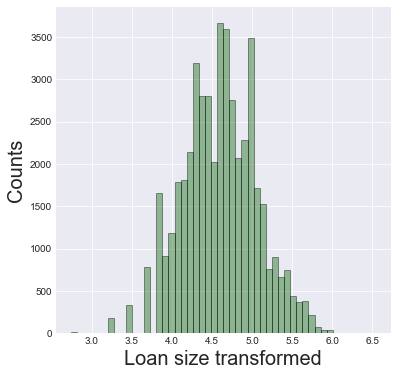

In [13]:
#plot of number of loans by size* size is scaled by log
j=sns.distplot(kiva['LOAN_BOX'].dropna(), kde=False, color='darkgreen', bins = 50)
j.figure.set_size_inches(6,6)
j.set_xlabel('Loan size transformed', size=20)
j.set_ylabel('Counts', size=20)
plt.savefig('Loan_size_transformed.png', dpi=300)

In [14]:
kiva['PRIMARY_GENDER'].value_counts()

Female    37188
Male      10200
Name: PRIMARY_GENDER, dtype: int64

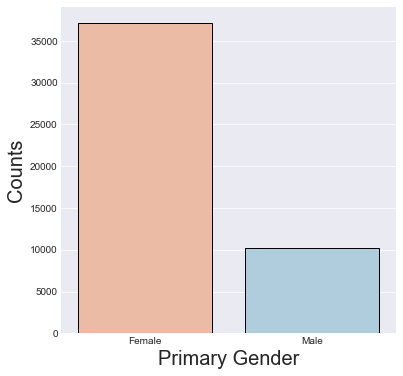

In [15]:
#plot of how long it takes projects to get funded
j=sns.countplot(kiva['PRIMARY_GENDER'], palette= 'RdBu')
j.figure.set_size_inches(6,6)
j.set_xlabel('Primary Gender', size=20)
j.set_ylabel('Counts', size=20)
plt.savefig('Primary_Gender.png', dpi=300)

# Investigate Sample Data by Country

In [16]:
#find the 20 most frequent countries
df_country = kiva.COUNTRY_NAME.value_counts().nlargest(20).reset_index()
df_country.columns=['COUNTRY_NAME','count']

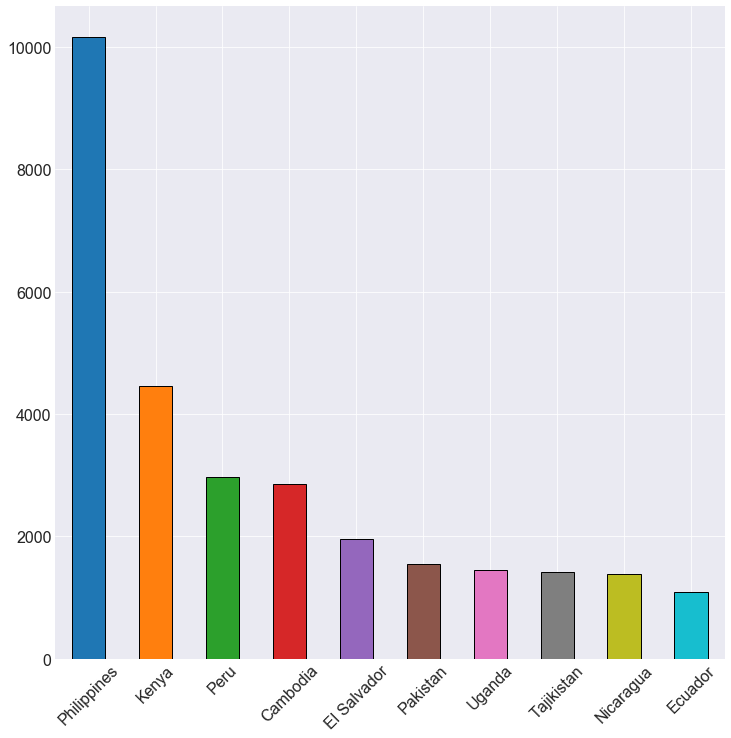

In [17]:
#Plot the 20 most frequent countries receiving loans
df_country = kiva.COUNTRY_NAME.value_counts().nlargest(10)
fig, axs = plt.subplots(1,1, figsize=(12,12))
df_country.plot.bar(rot='45', fontsize=16)
plt.savefig('top_5_country.png', dpi=300)

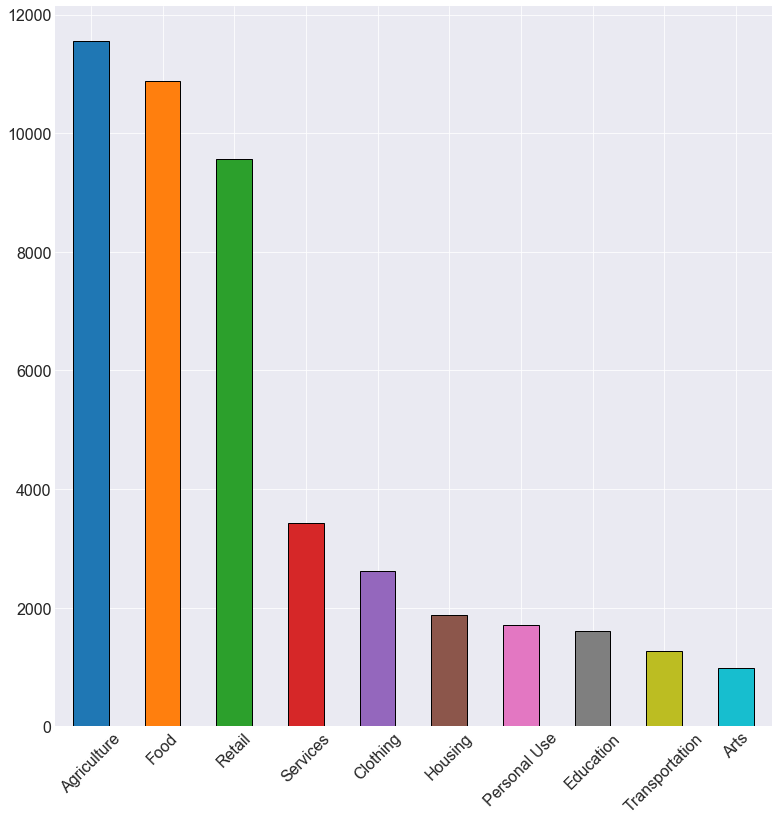

In [18]:
#plot the sectors receiving loans
df_sector = kiva.SECTOR_NAME.value_counts().nlargest(10)
fig, axs = plt.subplots(1,1, figsize=(12,12))
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15, left=.15)
df_sector.plot.bar(rot='45', fontsize=16)
plt.savefig('top_5_sector.png', dpi=300)

In [19]:
big_countries = kiva['COUNTRY_NAME'].value_counts().nlargest(5)
big_countries = big_countries.reset_index()
big_countries.columns=['COUNTRY_NAME', 'COUNT']
list_countries = big_countries['COUNTRY_NAME'].tolist()

In [20]:
big_sector = kiva['SECTOR_NAME'].value_counts().nlargest(5)
big_sector = big_sector.reset_index()
big_sector.columns=['SECTOR_NAME', 'COUNT']
list_sector = big_sector['SECTOR_NAME'].tolist()

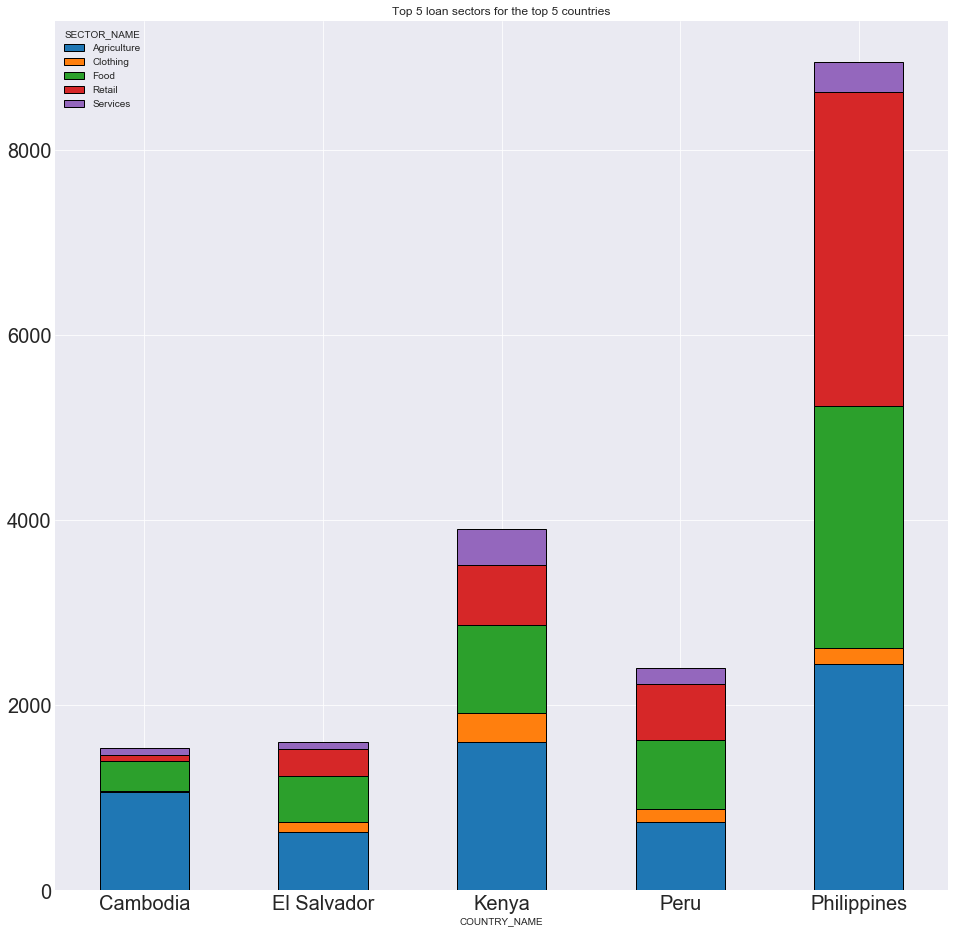

In [21]:
df_agg = kiva[(kiva['COUNTRY_NAME'].isin(list_countries)) & kiva['SECTOR_NAME'].isin(list_sector)].groupby(['COUNTRY_NAME'])['SECTOR_NAME'].value_counts().unstack()
df_agg.plot(kind='bar', stacked=True, figsize=(16,16), rot='0', fontsize=20, sort_columns=True, title='Top 5 loan sectors for the top 5 countries')
plt.savefig('top_5_country_sector.png', dpi=300)

# Further investigation into Kenya and Philippines

In [22]:
Kiva_Phil = kiva[kiva['COUNTRY_NAME']=='Philippines']
Kiva_Kenya = kiva[kiva['COUNTRY_NAME']=='Kenya']

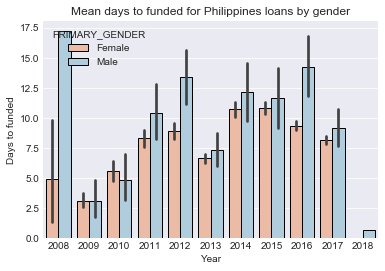

In [23]:
ax = sns.barplot(x='YEAR', y='DAYS_TO_FUND',
                 data=Kiva_Phil, 
                 hue='PRIMARY_GENDER', 
                 palette='RdBu')
ax.set(xlabel = 'Year', ylabel= 'Days to funded', title='Mean days to funded for Philippines loans by gender')
plt.savefig('philippines_gender.png', dpi=300)

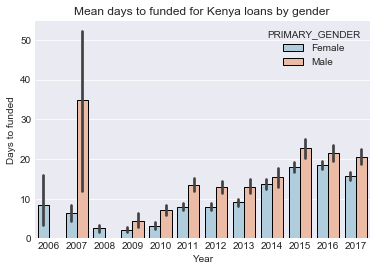

In [24]:
ax.legend(['Males', 'Females'])
ax = sns.barplot(x='YEAR', y='DAYS_TO_FUND',
                 data=Kiva_Kenya, 
                 hue='PRIMARY_GENDER', 
                 palette='RdBu_r')
ax.set(xlabel = 'Year', ylabel= 'Days to funded', title='Mean days to funded for Kenya loans by gender')
#ax.legend(loc='upper left')
#ax.get_legend_handles_labels(labels['Males', 'Females'])
plt.savefig('kenya_gender.png', dpi=300)

# Further exploration of Kenya

In [25]:
Kiva_CV = Kiva_Kenya.drop(['ORIGINAL_LANGUAGE', 'DESCRIPTION_TRANSLATED', 'FUNDED_AMOUNT', 'STATUS', 'IMAGE_ID',
                           'TOWN_NAME','CURRENCY_POLICY','POSTED_TIME',
                           'PLANNED_EXPIRATION_TIME','DISBURSE_TIME','RAISED_TIME','LENDER_TERM',
                           'TAGS','BORROWER_GENDERS','REPAYMENT_INTERVAL','DISTRIBUTION_MODEL',
                           'TIME_DELTA','FEMALE_BORROWERS','MALE_BORROWERS','YEAR','PERCENT_FEMALE',
                           'PRIMARY_GENDER', 'COUNTRY_NAME'],
                          axis=1)

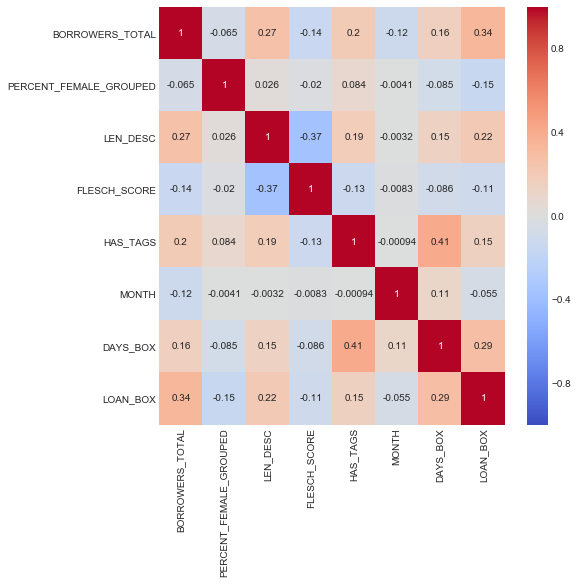

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(Kiva_CV.drop(['LOAN_AMOUNT','DAYS_TO_FUND'],1).corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True, ax=ax)
plt.gcf().subplots_adjust(bottom=0.3, left=.3)
plt.savefig('kenya_heatmap.png', dpi=300)

In [27]:
#Create X and y variables to 
y = Kiva_CV.dropna()['DAYS_BOX']
X = Kiva_CV.dropna().drop(['DAYS_BOX', 'PARTNER_ID', 'SECTOR_NAME', 'LOAN_ID', 'DAYS_TO_FUND', 'LOAN_AMOUNT', 'LEN_DESC'],1)
#Create a dummy variable of SECTOR_NAME
Dummy = patsy.dmatrix('SECTOR_NAME', data=Kiva_CV, return_type='dataframe')
X = X.join(Dummy)

In [28]:
#Make the train/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3)

In [29]:
#Run initial LinearRegression model
model= LinearRegression()
model.fit(X,y)
print('Linear Regression on entire dataset',model.score(X,y))

model.fit(X_train,y_train)
print('Train/Test/Split training', model.score(X_train,y_train))
print('Train/Test/Split testing', model.score(X_test,y_test))
reg = LinearRegression()

scores = cross_val_score(reg, X, y, cv=10, scoring='r2')
print('10 Fold Cross Validation', np.mean(scores))

Linear Regression on entire dataset 0.27933654341299263
Train/Test/Split training 0.27093167026000986
Train/Test/Split testing 0.2949937105209429
10 Fold Cross Validation 0.2701029782135722


In [30]:
#create a 2 degree polynomial and run linear regression on training data.
degree = 2
estlr = make_pipeline(PolynomialFeatures(degree), LinearRegression())
estlr.fit(X_train,y_train)
print ('2nd degree polynomial with linear regression training r^2', estlr.score(X_train,y_train))
print ('2nd degree polynomial with linear regression test r^2', estlr.score(X_test,y_test))

2nd degree polynomial with linear regression training r^2 0.3606920486906423
2nd degree polynomial with linear regression test r^2 0.3009829104515874


## Plotting residuals for 2 degree polynomial with Linear Regression

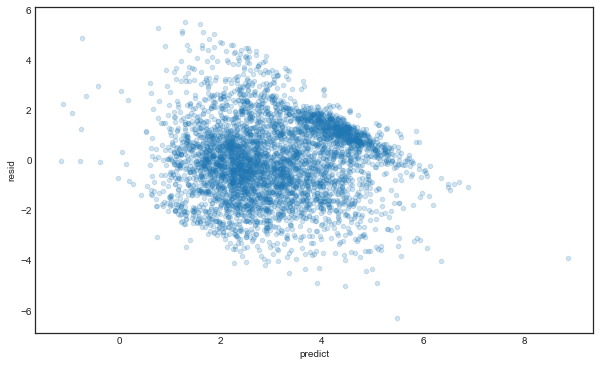

In [31]:
#plot the residuals. For a 2nd dimension polynomial linear regression
data_lr = pd.DataFrame(y)
data_lr['predict'] = estlr.predict(X)
data_lr['resid'] = (data_lr['DAYS_BOX'] - data_lr['predict'])

with sns.axes_style('white'):
    plot=data_lr.plot(kind='scatter',
                  x='predict',
                  y='resid',
                  alpha=.2,
                  figsize=(10,6),)
plt.savefig('resid.png', dpi=300)

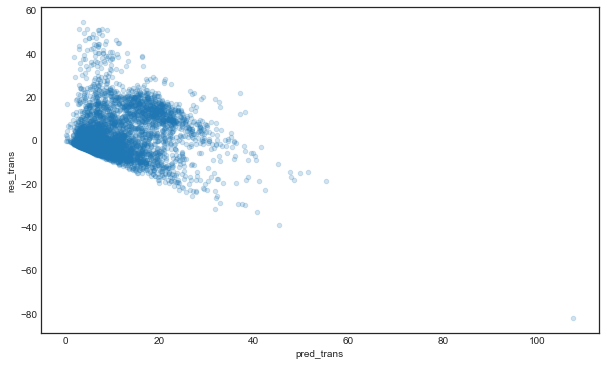

In [32]:
#plot the residuals, transformed back into their original units. For a 2nd dimension polynomial linear regression
data_lr = pd.DataFrame(y)
data_lr['predict'] = estlr.predict(X)
data_lr['resid'] = (data_lr['DAYS_BOX'] - data_lr['predict'])
data_lr['DAYS'] = inv_boxcox(data_lr['DAYS_BOX'], lmb_days)
data_lr['pred_trans'] = inv_boxcox(data_lr['predict'], lmb_days)
data_lr['res_trans'] = (data_lr['DAYS'] - data_lr['pred_trans'])
with sns.axes_style('white'):
    plot=data_lr.plot(kind='scatter',
                  x='pred_trans',
                  y='res_trans',
                  alpha=.2,
                  figsize=(10,6),)
plt.savefig('trans_resid.png', dpi=300)

In [33]:
data_lr['pred_trans'].max()

107.63884191235024

## View summary statistics of linear regression model for Kenya data

In [34]:
lreg_kenya = sm.OLS(y,X)
lr_kenya = lreg_kenya.fit()
lr_kenya.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               DAYS_BOX   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     86.09
Date:                Thu, 26 Apr 2018   Prob (F-statistic):          4.09e-297
Time:                        19:28:03   Log-Likelihood:                -8431.3
No. Observations:                4463   AIC:                         1.690e+04
Df Residuals:                    4442   BIC:                         1.704e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
BORROWERS_TOTAL                   0.0159      0.010      1.522      0.128      -0.005       0.036
PERCENT_FEMALE_GROUPED           -0.4225      0.060     -7.100      0.000      -0.539      -0.306
FLESCH_SCORE                     -0.0105      0.004     -2.926      0.003      -0.017      -0.003
HAS_TAGS                          1.4610      0.051     28.756      0.000       1.361       1.561
MONTH                             0.0639      0.007      9.287      0.000       0.050       0.077
LOAN_BOX                          0.9998      0.073     13.608      0.000       0.856       1.144
Intercept                        -1.3738      0.453     -3.036      0.002      -2.261      -0.487
SECTOR_NAME[T.Arts]              -0.4201      0.354     -1.188      0.235      -1.113       0.273
SECTOR_NAME[T.Clothing]           0.6272      0.103      6.109      0.000       0.426       0.828
SECTOR_NAME[T.Construction]      -0.5470      0.207     -2.639      0.008      -0.953      -0.141
SECTOR_NAME[T.Education]         -1.0864      0.185     -5.866      0.000      -1.450      -0.723
SECTOR_NAME[T.Entertainment]     -1.0698      0.720     -1.487      0.137      -2.481       0.341
SECTOR_NAME[T.Food]               0.0437      0.069      0.629      0.529      -0.092       0.180
SECTOR_NAME[T.Health]            -0.8767      0.229     -3.833      0.000      -1.325      -0.428
SECTOR_NAME[T.Housing]           -0.8278      0.275     -3.009      0.003      -1.367      -0.288
SECTOR_NAME[T.Manufacturing]     -1.4304      0.254     -5.631      0.000      -1.929      -0.932
SECTOR_NAME[T.Personal Use]      -0.7597      0.152     -4.985      0.000      -1.058      -0.461
SECTOR_NAME[T.Retail]             0.3926      0.078      5.009      0.000       0.239       0.546
SECTOR_NAME[T.Services]          -0.0057      0.093     -0.061      0.951      -0.189       0.177
SECTOR_NAME[T.Transportation]     0.4761      0.157      3.030      0.002       0.168       0.784
SECTOR_NAME[T.Wholesale]         -1.5652      0.720     -2.173      0.030      -2.977      -0.153
==============================================================================
Omnibus:                        2.284   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                2.224
Skew:                           0.048   Prob(JB):                        0.329
Kurtosis:                       3.053   Cond. No.                     2.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Investigating Lasso model

In [35]:
y_lasso = Kiva_CV.dropna()['DAYS_BOX']
X_lasso = Kiva_CV.dropna().drop(['DAYS_BOX', 'PARTNER_ID', 'SECTOR_NAME', 'LOAN_ID', 'DAYS_TO_FUND', 'LOAN_AMOUNT', 'LEN_DESC'],1)
Dummy_lasso = patsy.dmatrix('SECTOR_NAME', data=Kiva_CV, return_type='dataframe')
X_lasso = X_lasso.join(Dummy_lasso)
#X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=.3)

In [36]:
#test 6 different alpha values for the dataset, choose alpha to use that produces lowest error.
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
val_errors = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True)
    errors = np.sum(-cross_val_score(lasso, 
                                     X= X_lasso, 
                                     y= y_lasso, 
                                     scoring='neg_mean_squared_error', 
                                     cv=10))
    val_errors.append(np.sqrt(errors))
val_errors
alpha_to_use = alphas[val_errors.index(min(val_errors))]

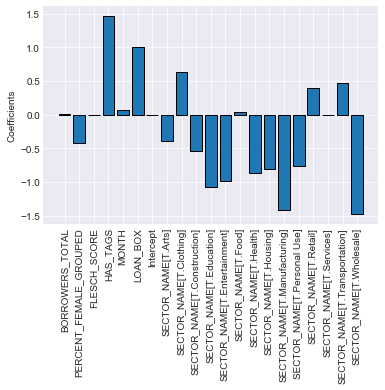

In [144]:
lasso = Lasso(alpha=alpha_to_use)
lasso_coef = lasso.fit(X, y).coef_
_ = plt.bar(range(len(X.columns)), lasso_coef)
_ = plt.xticks(range(len(X.columns)), X.columns, rotation=90)
_ = plt.ylabel('Coefficients')
plt.savefig('lasso_coef_kenya.png', dpi=300)

The loop above choose the best alpha for the model (minimizing mean_squared_error), it is interesting and I am uncertain why the lasso and ridge models create coefficient plots that look very similar.

In [41]:
print ('Lasso model with α:', alpha_to_use, 'and r^2:', lasso.score(X,y))

Lasso model with α: 0.0001 and r^2: 0.27932892439603785


## Investigating Ridge model

In [42]:
y_ridge = Kiva_CV['DAYS_BOX']
X_ridge = Kiva_CV.drop(['DAYS_BOX', 'PARTNER_ID', 'SECTOR_NAME', 'LOAN_ID', 'DAYS_TO_FUND', 'LOAN_AMOUNT', 'LEN_DESC'],1)
Dummy_ridge = patsy.dmatrix('SECTOR_NAME', data=Kiva_CV, return_type='dataframe')
X_ridge = X_ridge.join(Dummy_ridge)
#X_train_intermediate, X_test_ridge, y_train_intermediate, y_test_ridge = train_test_split(X_ridge, y_ridge, test_size=.3)
#X_train_ridge, X_validation_ridge, y_train_ridge, y_validation_ridge = train_test_split(X_train_intermediate, y_train_intermediate, test_size=.3)

In [43]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5]
val_errors_ridge = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    errors = np.sum(-cross_val_score(ridge, 
                                     X= X_ridge, 
                                     y= y_ridge, 
                                     scoring='neg_mean_squared_error', 
                                     cv=10))
    val_errors_ridge.append(np.sqrt(errors))
val_errors_ridge
alpha_to_use_ridge = alphas[val_errors_ridge.index(min(val_errors_ridge))]

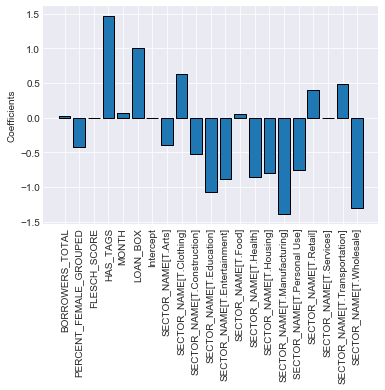

In [146]:
ridge = Ridge(alpha=alpha_to_use_ridge)
ridge_coef = ridge.fit(X, y).coef_
_ = plt.bar(range(len(X.columns)), ridge_coef)
_ = plt.xticks(range(len(X.columns)), X.columns, rotation=90)
_ = plt.ylabel('Coefficients')
plt.savefig('ridge_coef_kenya.png', dpi=300)

The loop above choose the best alpha for the model (minimizing mean_squared_error), it is interesting and I am uncertain why the lasso and ridge models create coefficient plots that look very similar. This happens for both my Kenya and Philippines data sets.

In [45]:
print ('Ridge model with α:', alpha_to_use_ridge, 'and r^2:', ridge.score(X,y))

Ridge model with α: 1 and r^2: 0.27929579596324344


# Investigating a 3rd degree Polynomial Distribution with ElasticnetCV

In [99]:
degree = 3
l1rat = [0,.1,.2,.5, .7, .9, .95, .99, 1]
α = [1e-5,1e-4,1e-3,1e-2,1e-1,1e0, 1e1]
entcv = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio=l1rat, alphas=α))
entcv.fit(X,y)
print("alpha =", entcv.named_steps.elasticnetcv.alpha_, "l1_ratio =",
      entcv.named_steps.elasticnetcv.l1_ratio_)

alpha = 0.1 l1_ratio = 0.7


In [105]:
entcv.score(X,y)

0.34939144309841397

## Calculating adjusted r^2

In [106]:
coef_df = pd.DataFrame()
poly = entcv.steps[0][1]
coef_df['feature'] = poly.get_feature_names(X.columns)
coef_df['coefficient'] = entcv.steps[-1][1].coef_.ravel()
#len(coef_df[coef_df['coefficient'] != 0].sort_values('coefficient'))

2024

In [107]:
r2_adj_kenya = 1 - ((1-entcv.score(X,y))*(len(X)-1)/(len(X)-len(coef_df[coef_df['coefficient'] != 0].sort_values('coefficient'))-1))

In [108]:
r2_adj_kenya

0.3346286085503377

In [125]:
coef_plot = coef_df.nlargest(5, 'coefficient')

coef_plot = coef_plot.append(coef_df.nsmallest(5,'coefficient'))

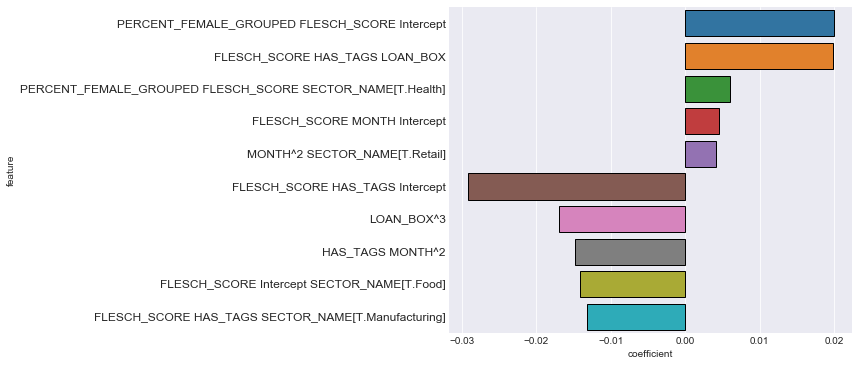

In [163]:
#Create a plot of the largest & smallest coefficients
ax = sns.barplot(x='coefficient', y='feature', data=coef_plot)
plt.rcParams['figure.figsize']=(14,6)
ax.set_yticklabels(coef_plot.feature, fontsize=12);
plt.gcf().subplots_adjust(left=.5)
plt.savefig('enetcv_coef_plot.png', dpi=300)

In [142]:
#coef_df[coef_df['coefficient'] != 0].sort_values('coefficient')

## Plotting residuals for 3 degree polynomial with ElasticNetCV

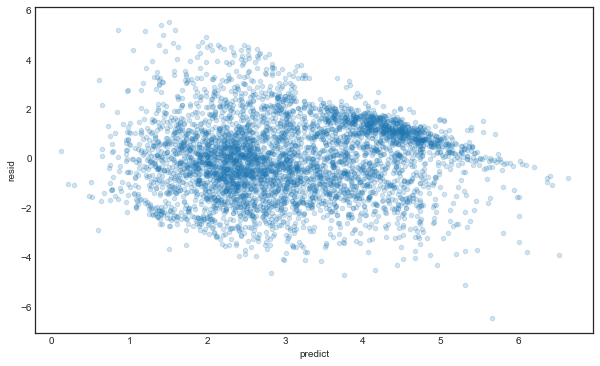

In [148]:
data = pd.DataFrame(y)
data['predict'] = entcv.predict(X)
data['resid'] = (data['DAYS_BOX'] - data['predict'])

with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='predict',
                  y='resid',
                  alpha=.2,
                  figsize=(10,6),)
plt.savefig('resid_kenya.png', dpi=300)

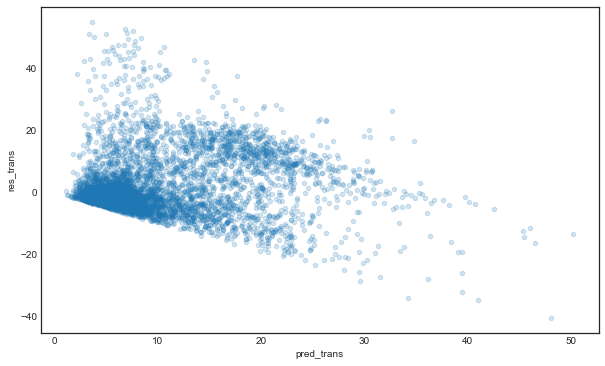

In [149]:
data = pd.DataFrame(y)
data['predict'] = entcv.predict(X)
data['resid'] = (data['DAYS_BOX'] - data['predict'])
data['DAYS'] = inv_boxcox(data['DAYS_BOX'], lmb_days)
data['pred_trans'] = inv_boxcox(data['predict'], lmb_days)
data['res_trans'] = (data['DAYS'] - data['pred_trans'])
with sns.axes_style('white'):
    plot=data.plot(kind='scatter',
                  x='pred_trans',
                  y='res_trans',
                  alpha=.2,
                  figsize=(10,6),)
plt.savefig('trans_resid_kenya.png', dpi=300)

# Investigating Philippines Data

In [55]:
Phil_CV = Kiva_Phil.drop(['ORIGINAL_LANGUAGE', 'DESCRIPTION_TRANSLATED', 'FUNDED_AMOUNT', 'STATUS', 'IMAGE_ID',
                           'TOWN_NAME','CURRENCY_POLICY','POSTED_TIME',
                           'PLANNED_EXPIRATION_TIME','DISBURSE_TIME','RAISED_TIME','LENDER_TERM',
                           'TAGS','BORROWER_GENDERS','REPAYMENT_INTERVAL','DISTRIBUTION_MODEL',
                           'TIME_DELTA','FEMALE_BORROWERS','MALE_BORROWERS','YEAR','PERCENT_FEMALE',
                           'PRIMARY_GENDER', 'COUNTRY_NAME'],
                          axis=1)

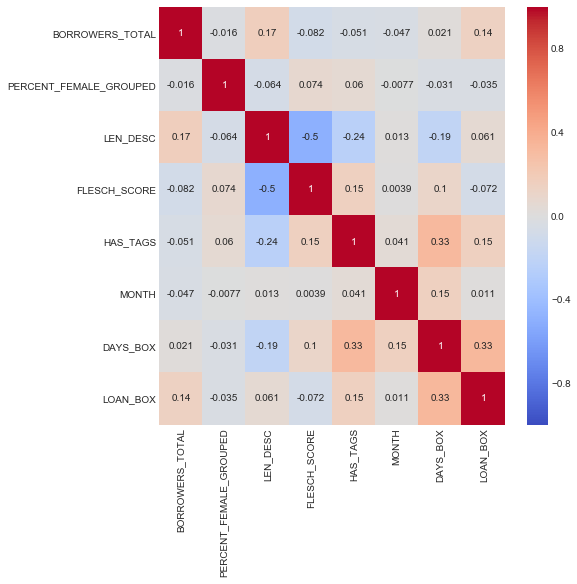

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(Phil_CV.drop(['LOAN_AMOUNT','DAYS_TO_FUND'],1).corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True, ax=ax)
plt.gcf().subplots_adjust(bottom=0.3, left=.3,)
plt.savefig('phil_heatmap.png', dpi=300)

In [57]:
#Create X and y variables to 
y_phil = Phil_CV.dropna()['DAYS_BOX']
X_phil = Phil_CV.dropna().drop(['DAYS_BOX', 'PARTNER_ID', 'SECTOR_NAME', 'LOAN_ID', 'DAYS_TO_FUND', 'LOAN_AMOUNT', 'LEN_DESC'],1)
#Create a dummy variable of SECTOR_NAME
Dummy = patsy.dmatrix('SECTOR_NAME', data=Phil_CV, return_type='dataframe')
X_phil = X_phil.join(Dummy)

In [58]:
#Make the train/test splits
X_train, X_test, y_train, y_test = train_test_split(X_phil, y_phil, test_size=.3)

In [59]:
#Run initial LinearRegression model
model= LinearRegression()
model.fit(X_phil,y_phil)
print('Linear Regression on entire dataset',model.score(X_phil,y_phil))

model.fit(X_train,y_train)
print('Train/Test/Split training', model.score(X_train,y_train))
print('Train/Test/Split testing', model.score(X_test,y_test))
reg = LinearRegression()

scores = cross_val_score(reg, X_phil, y_phil, cv=10, scoring='r2')
print('10 Fold Cross Validation', np.mean(scores))

Linear Regression on entire dataset 0.22754354439759475
Train/Test/Split training 0.22871727961013222
Train/Test/Split testing 0.2211239514991752
10 Fold Cross Validation 0.22340397843176482


In [60]:
#create a 2 degree polynomial and run linear regression on training data.
degree = 2
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
est.fit(X_train,y_train)
print ('2nd degree polynomial with linear regression training r^2', est.score(X_train,y_train))
print ('2nd degree polynomial with linear regression test r^2', est.score(X_test,y_test))

2nd degree polynomial with linear regression training r^2 0.3085598035095509
2nd degree polynomial with linear regression test r^2 0.2551195252905776


## Investigating Lasso model

In [61]:
y_lasso = Phil_CV.dropna()['DAYS_BOX']
X_lasso = Phil_CV.dropna().drop(['DAYS_BOX', 'PARTNER_ID', 'SECTOR_NAME', 'LOAN_ID', 'DAYS_TO_FUND', 'LOAN_AMOUNT', 'LEN_DESC'],1)
Dummy_lasso = patsy.dmatrix('SECTOR_NAME', data=Phil_CV, return_type='dataframe')
X_lasso = X_lasso.join(Dummy_lasso)
#X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso, test_size=.3)

In [62]:
#test 6 different alpha values for the dataset, choose alpha to use that produces lowest error.
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1]
val_errors = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, fit_intercept=True)
    errors = np.sum(-cross_val_score(lasso, 
                                     X= X_lasso, 
                                     y= y_lasso, 
                                     scoring='neg_mean_squared_error', 
                                     cv=10))
    val_errors.append(np.sqrt(errors))
val_errors
alpha_to_use = alphas[val_errors.index(min(val_errors))]

In [63]:
coef_df = pd.DataFrame()
poly = est.steps[0][1]
coef_df['feature'] = poly.get_feature_names(X_phil.columns)
coef_df['coefficient'] = est.steps[-1][1].coef_.ravel()
#coef_df[coef_df['coefficient'] != 0].sort_values('coefficient')

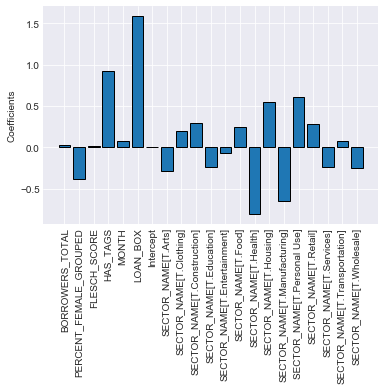

In [145]:
lasso = Lasso(alpha=alpha_to_use)
lasso_coef = lasso.fit(X_phil, y_phil).coef_
_ = plt.bar(range(len(X_phil.columns)), lasso_coef)
_ = plt.xticks(range(len(X_phil.columns)), X_phil.columns, rotation=90)
_ = plt.ylabel('Coefficients')
plt.savefig('lasso_coef_phil.png', dpi=300)

In [65]:
print ('Lasso model with α:', alpha_to_use, 'and r^2:', lasso.score(X_phil,y_phil))

Lasso model with α: 0.0001 and r^2: 0.22753156959885845


## Investigating Ridge model

In [66]:
y_ridge = Phil_CV['DAYS_BOX']
X_ridge = Phil_CV.drop(['DAYS_BOX', 'PARTNER_ID', 'SECTOR_NAME', 'LOAN_ID', 'DAYS_TO_FUND', 'LOAN_AMOUNT', 'LEN_DESC'],1)
Dummy_ridge = patsy.dmatrix('SECTOR_NAME', data=Phil_CV, return_type='dataframe')
X_ridge = X_ridge.join(Dummy_ridge)
#X_train_intermediate, X_test_ridge, y_train_intermediate, y_test_ridge = train_test_split(X_ridge, y_ridge, test_size=.3)
#X_train_ridge, X_validation_ridge, y_train_ridge, y_validation_ridge = train_test_split(X_train_intermediate, y_train_intermediate, test_size=.3)

In [67]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2]
val_errors_ridge = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    errors = np.sum(-cross_val_score(ridge, 
                                     X= X_ridge, 
                                     y= y_ridge, 
                                     scoring='neg_mean_squared_error', 
                                     cv=10))
    val_errors_ridge.append(np.sqrt(errors))
val_errors_ridge
alpha_to_use_ridge = alphas[val_errors_ridge.index(min(val_errors_ridge))]
ridge.fit(X,y)

Ridge(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [68]:
print ('Ridge model with α:', alpha_to_use_ridge, 'and r^2:', ridge.score(X_phil,y_phil))

Ridge model with α: 1 and r^2: 0.05828685093916908


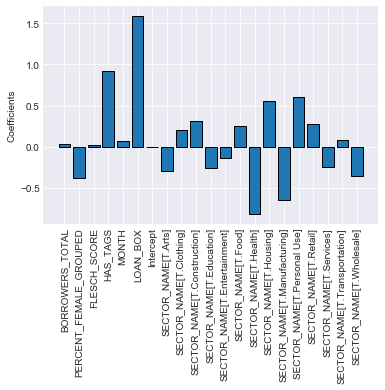

In [147]:
ridge = Ridge(alpha=alpha_to_use_ridge)
ridge_coef = ridge.fit(X_phil, y_phil).coef_
_ = plt.bar(range(len(X_phil.columns)), ridge_coef)
_ = plt.xticks(range(len(X_phil.columns)), X_phil.columns, rotation=90)
_ = plt.ylabel('Coefficients')
plt.savefig('ridge_coef_phil.png', dpi=300)

# Investigating a 2nd degree polynomial distribution with ElasticnetCV

In [70]:
degree = 2
l1rat = [0,.1,.2,.5, .7, .9, .95, .99, 1]
α = [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]
entcv_phil = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio=l1rat, alphas=α))
entcv_phil.fit(X_phil,y_phil)
print("alpha =", entcv.named_steps.elasticnetcv.alpha_, "l1_ratio =",
      entcv.named_steps.elasticnetcv.l1_ratio_)

alpha = 0.1 l1_ratio = 0.7


In [71]:
#pred_y = entcv_phil.predict(X_phil)
entcv_phil.score(X_phil,y_phil)

0.29406783084539

## Plotting residuals for 2nd degree polynomial with ElasticNetCV

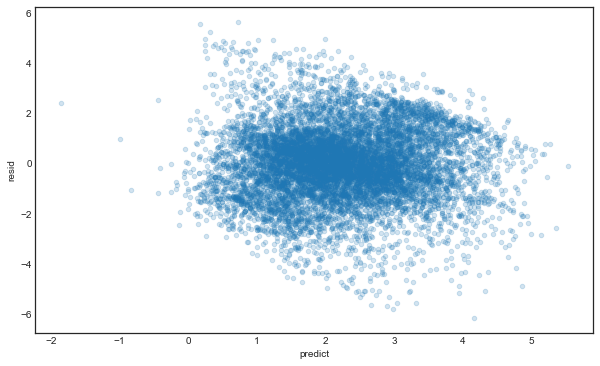

In [150]:
data_phil = pd.DataFrame(y_phil)
data_phil['predict'] = entcv_phil.predict(X_phil)
data_phil['resid'] = (data_phil['DAYS_BOX'] - data_phil['predict'])

with sns.axes_style('white'):
    plot=data_phil.plot(kind='scatter',
                  x='predict',
                  y='resid',
                  alpha=.2,
                  figsize=(10,6),)
plt.savefig('resid_phil_2d.png', dpi=300)

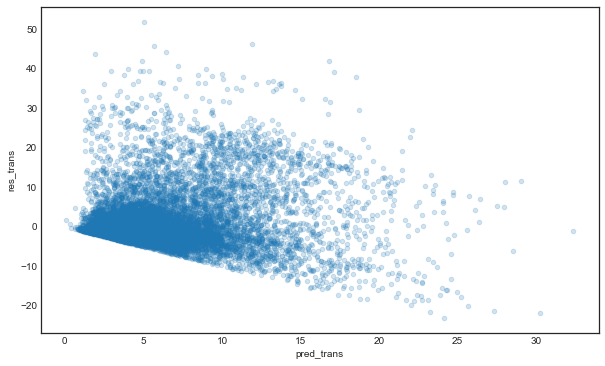

In [151]:
data_phil = pd.DataFrame(y_phil)
data_phil['predict'] = entcv_phil.predict(X_phil)
data_phil['resid'] = (data_phil['DAYS_BOX'] - data_phil['predict'])
data_phil['DAYS'] = inv_boxcox(data_phil['DAYS_BOX'], lmb_days)
data_phil['pred_trans'] = inv_boxcox(data_phil['predict'], lmb_days)
data_phil['res_trans'] = (data_phil['DAYS'] - data_phil['pred_trans'])
with sns.axes_style('white'):
    plot=data_phil.plot(kind='scatter',
                  x='pred_trans',
                  y='res_trans',
                  alpha=.2,
                  figsize=(10,6),)
plt.savefig('resid_phil_2d_trans.png', dpi=300)

## Calculating adjusted r^2

In [74]:
coef_df_phil = pd.DataFrame()
poly_phil = entcv_phil.steps[0][1]
coef_df_phil['feature'] = poly_phil.get_feature_names(X_phil.columns)
coef_df_phil['coefficient'] = entcv_phil.steps[-1][1].coef_.ravel()
#len(coef_df_phil[coef_df_phil['coefficient'] != 0].sort_values('coefficient'))

In [75]:
#coef_df_phil[coef_df_phil['coefficient'] != 0].sort_values('coefficient')

In [76]:
r2_adj_phil = 1 - ((1-entcv_phil.score(X_phil,y_phil))*(len(X_phil)-1)/(len(X_phil)-len(coef_df_phil[coef_df_phil['coefficient'] != 0].sort_values('coefficient'))-1))

In [77]:
r2_adj_phil

0.2828412640424711

# Investigating a 3rd degree polynomial distribution with ElasticnetCV

In [78]:
degree = 3
l1rat = [0,.1,.2,.5, .7, .9, .95, .99, 1]
α = [1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1]
entcv_phil = make_pipeline(PolynomialFeatures(degree), ElasticNetCV(l1_ratio=l1rat, alphas=α))
entcv_phil.fit(X_phil,y_phil)
print("alpha =", entcv.named_steps.elasticnetcv.alpha_, "l1_ratio =",
      entcv.named_steps.elasticnetcv.l1_ratio_)

alpha = 0.1 l1_ratio = 0.7


In [79]:
#pred_y = entcv_phil.predict(X)
entcv_phil.score(X_phil,y_phil)

0.29880639645709905

## Plotting residuals for 3rd degree polynomial with ElasticNetCV

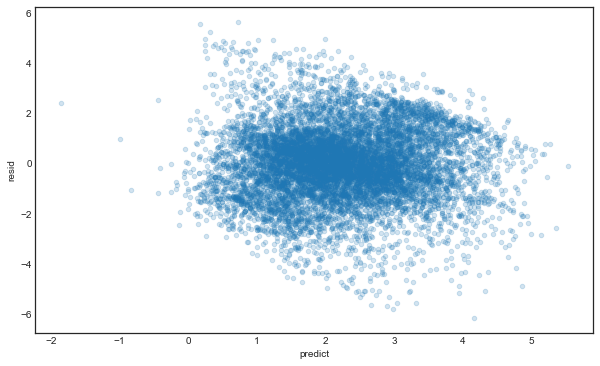

In [152]:
data_phil = pd.DataFrame(y_phil)
data_phil['predict'] = entcv_phil.predict(X_phil)
data_phil['resid'] = (data_phil['DAYS_BOX'] - data_phil['predict'])

with sns.axes_style('white'):
    plot=data_phil.plot(kind='scatter',
                  x='predict',
                  y='resid',
                  alpha=.2,
                  figsize=(10,6),)
plt.savefig('resid_phil_3d.png', dpi=300)

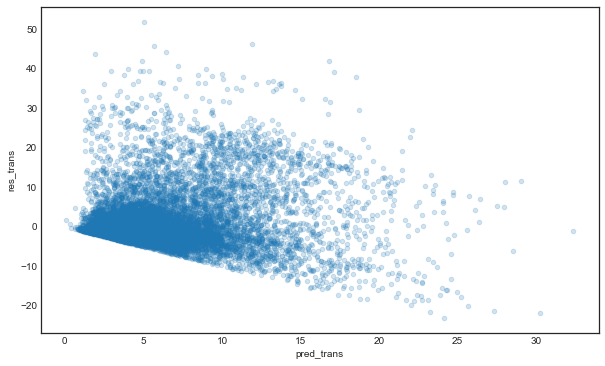

In [153]:
data_phil = pd.DataFrame(y_phil)
data_phil['predict'] = entcv_phil.predict(X_phil)
data_phil['resid'] = (data_phil['DAYS_BOX'] - data_phil['predict'])
data_phil['DAYS'] = inv_boxcox(data_phil['DAYS_BOX'], lmb_days)
data_phil['pred_trans'] = inv_boxcox(data_phil['predict'], lmb_days)
data_phil['res_trans'] = (data_phil['DAYS'] - data_phil['pred_trans'])
with sns.axes_style('white'):
    plot=data_phil.plot(kind='scatter',
                  x='pred_trans',
                  y='res_trans',
                  alpha=.2,
                  figsize=(10,6),)
plt.savefig('resid_phil_3d_trans.png', dpi=300)

## Calculating adjusted r^2

In [166]:
coef_df_phil = pd.DataFrame()
poly_phil = entcv_phil.steps[0][1]
coef_df_phil['feature'] = poly_phil.get_feature_names(X_phil.columns)
coef_df_phil['coefficient'] = entcv_phil.steps[-1][1].coef_.ravel()
#len(coef_df_phil[coef_df_phil['coefficient'] != 0].sort_values('coefficient'))

In [167]:
coef_plot_phil = coef_df_phil.nlargest(5, 'coefficient')
coef_plot_phil = coef_plot_phil.append(coef_df_phil.nsmallest(5,'coefficient'))

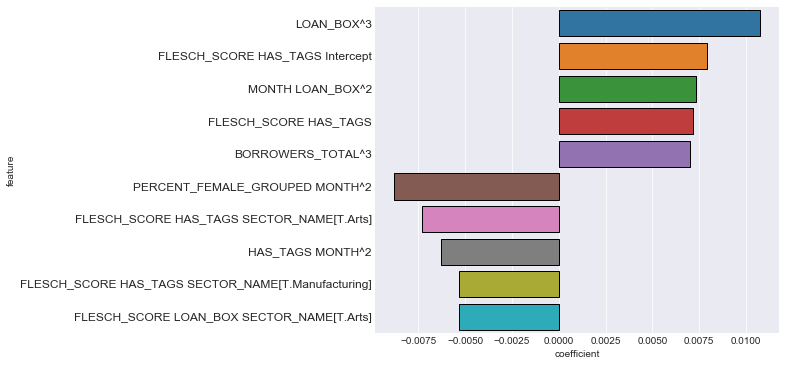

In [168]:
#Create a plot of the largest & smallest coefficients
ax = sns.barplot(x='coefficient', y='feature', data=coef_plot_phil)
plt.rcParams['figure.figsize']=(14,6)
ax.set_yticklabels(coef_plot_phil.feature, fontsize=12);
plt.gcf().subplots_adjust(left=.5)
plt.savefig('enetcv_coef_plot_phil.png', dpi=300)

In [83]:
#coef_df_phil[coef_df_phil['coefficient'] != 0].sort_values('coefficient')

In [84]:
r2_adj = 1 - ((1-entcv_phil.score(X_phil,y_phil))*(len(X_phil)-1)/(len(X_phil)-len(coef_df_phil[coef_df_phil['coefficient'] != 0].sort_values('coefficient'))-1))

In [170]:
r2_adj_phil

0.2828412640424711

## View summary statistics for a linear regression for Philippines data

In [86]:
lreg_phil = sm.OLS(y,X)
lr_phil = lreg_phil.fit()
lr_phil.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               DAYS_BOX   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     86.09
Date:                Thu, 26 Apr 2018   Prob (F-statistic):          4.09e-297
Time:                        19:34:30   Log-Likelihood:                -8431.3
No. Observations:                4463   AIC:                         1.690e+04
Df Residuals:                    4442   BIC:                         1.704e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
BORROWERS_TOTAL                   0.0159      0.010      1.522      0.128      -0.005       0.036
PERCENT_FEMALE_GROUPED           -0.4225      0.060     -7.100      0.000      -0.539      -0.306
FLESCH_SCORE                     -0.0105      0.004     -2.926      0.003      -0.017      -0.003
HAS_TAGS                          1.4610      0.051     28.756      0.000       1.361       1.561
MONTH                             0.0639      0.007      9.287      0.000       0.050       0.077
LOAN_BOX                          0.9998      0.073     13.608      0.000       0.856       1.144
Intercept                        -1.3738      0.453     -3.036      0.002      -2.261      -0.487
SECTOR_NAME[T.Arts]              -0.4201      0.354     -1.188      0.235      -1.113       0.273
SECTOR_NAME[T.Clothing]           0.6272      0.103      6.109      0.000       0.426       0.828
SECTOR_NAME[T.Construction]      -0.5470      0.207     -2.639      0.008      -0.953      -0.141
SECTOR_NAME[T.Education]         -1.0864      0.185     -5.866      0.000      -1.450      -0.723
SECTOR_NAME[T.Entertainment]     -1.0698      0.720     -1.487      0.137      -2.481       0.341
SECTOR_NAME[T.Food]               0.0437      0.069      0.629      0.529      -0.092       0.180
SECTOR_NAME[T.Health]            -0.8767      0.229     -3.833      0.000      -1.325      -0.428
SECTOR_NAME[T.Housing]           -0.8278      0.275     -3.009      0.003      -1.367      -0.288
SECTOR_NAME[T.Manufacturing]     -1.4304      0.254     -5.631      0.000      -1.929      -0.932
SECTOR_NAME[T.Personal Use]      -0.7597      0.152     -4.985      0.000      -1.058      -0.461
SECTOR_NAME[T.Retail]             0.3926      0.078      5.009      0.000       0.239       0.546
SECTOR_NAME[T.Services]          -0.0057      0.093     -0.061      0.951      -0.189       0.177
SECTOR_NAME[T.Transportation]     0.4761      0.157      3.030      0.002       0.168       0.784
SECTOR_NAME[T.Wholesale]         -1.5652      0.720     -2.173      0.030      -2.977      -0.153
==============================================================================
Omnibus:                        2.284   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.319   Jarque-Bera (JB):                2.224
Skew:                           0.048   Prob(JB):                        0.329
Kurtosis:                       3.053   Cond. No.                     2.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
# coef_df = pd.DataFrame()
# poly = est.steps[0][1]
# coef_df['feature'] = poly.get_feature_names(X.columns)
# coef_df['coefficient'] = est.steps[-1][1].coef_.ravel()
# #coef_df[coef_df['coefficient'] != 0].sort_values('coefficient')